# 注意力评分函数
:label:`sec_attention-scoring-functions`


在 :numref:`sec_attention-pooling` 中，
我们使用了多种基于距离的核函数，包括高斯核来建模查询和键之间的交互。事实证明，距离函数比点积稍微昂贵一些。因此，
通过 softmax 操作确保非负注意力权重，
大部分工作都集中在 *注意力评分函数* $a$ 上，如 :eqref:`eq_softmax_attention` 和 :numref:`fig_attention_output` 所示，这些函数更易于计算。

![计算注意力池化的输出作为值的加权平均，其中权重是通过注意力评分函数 $\mathit{a}$ 和 softmax 操作计算得出的。](../img/attention-output.svg)
:label:`fig_attention_output`

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## [**点积注意力**]

让我们回顾一下来自高斯核的注意力函数（不带指数部分）：

$$
a(\mathbf{q}, \mathbf{k}_i) = -\frac{1}{2} \|\mathbf{q} - \mathbf{k}_i\|^2  = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} \|\mathbf{k}_i\|^2  -\frac{1}{2} \|\mathbf{q}\|^2.
$$

首先，注意最后一项仅依赖于$\mathbf{q}$。因此，对于所有$(\mathbf{q}, \mathbf{k}_i)$对来说它是相同的。将注意力权重标准化为$1$，如:eqref:`eq_softmax_attention`所示，确保了这一项完全消失。其次，注意批量归一化和层归一化（稍后讨论）导致激活具有良好限制的、通常是常数的范数$\|\mathbf{k}_i\|$。例如，当键$\mathbf{k}_i$是由层归一化生成时就是这种情况。因此，我们可以从$a$的定义中去掉它而不会对结果产生重大影响。

最后，我们需要控制指数函数参数的数量级。假设查询$\mathbf{q} \in \mathbb{R}^d$和键$\mathbf{k}_i \in \mathbb{R}^d$的所有元素都是独立且同分布的随机变量，均值为零，方差为1。两向量之间的点积具有零均值和$d$的方差。为了确保无论向量长度如何，点积的方差仍然保持为1，我们使用*缩放点积注意力*评分函数。也就是说，我们将点积除以$1/\sqrt{d}$。因此，我们得到了第一个常用的注意力函数，例如在Transformers :cite:`Vaswani.Shazeer.Parmar.ea.2017`中使用：

$$ a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i / \sqrt{d}.$$
:eqlabel:`eq_dot_product_attention`

请注意，注意力权重$\alpha$仍需要标准化。通过:eqref:`eq_softmax_attention`我们可以进一步简化，使用softmax操作：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.$$
:eqlabel:`eq_attn-scoring-alpha`

事实证明，所有流行的注意力机制都使用了softmax，因此我们在本章的其余部分将仅限于此。

## 便利函数

我们需要一些函数来使注意力机制高效部署。这包括处理可变长度字符串（自然语言处理中常见）的工具以及在小批量上有效评估的工具（批量矩阵乘法）。

### [**掩码Softmax操作**]

注意力机制最流行的应用之一是序列模型。因此我们需要能够处理不同长度的序列。在某些情况下，这些序列可能会出现在同一个迷你批次中，这就需要用虚拟标记来填充较短的序列（参见:numref:`sec_machine_translation`中的示例）。这些特殊标记没有意义。例如，假设我们有以下三个句子：

```
Dive  into  Deep    Learning 
Learn to    code    <blank>
Hello world <blank> <blank>
```

由于我们不想在注意力模型中包含空白，所以我们只需将$\sum_{i=1}^n \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$限制为$\sum_{i=1}^l \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$，其中$l \leq n$是实际句子的长度。由于这是一个非常常见的问题，它有一个名称：*掩码softmax操作*。

让我们实现它。实际上，实现稍微有点作弊，它将$i > l$时的$\mathbf{v}_i$的值设为零。此外，它将注意力权重设置为一个很大的负数，比如$-10^{6}$，以便在实践中使它们对梯度和值的贡献消失。这样做是因为线性代数内核和运算符针对GPU进行了高度优化，计算稍微浪费一点比代码中有条件语句（if then else）要快。

In [2]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

为了说明这个函数是如何工作的，考虑一个大小为 $2 \times 4$ 的两个样本的迷你批次，它们的有效长度分别为 $2$ 和 $3$。经过掩码 softmax 操作后，每对向量中超出有效长度的值都被掩码为零。

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4448, 0.5552, 0.0000, 0.0000],
         [0.4032, 0.5968, 0.0000, 0.0000]],

        [[0.2795, 0.2805, 0.4400, 0.0000],
         [0.2798, 0.3092, 0.4110, 0.0000]]])

如果需要更精细地控制每个示例中两个向量的有效长度，我们只需使用一个二维的有效长度张量。这样就可以得到：

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4109, 0.2794, 0.3097, 0.0000]],

        [[0.3960, 0.6040, 0.0000, 0.0000],
         [0.2557, 0.1833, 0.2420, 0.3190]]])

### 批矩阵乘法
:label:`subsec_batch_dot`

另一个常用的操作是将一批矩阵相互相乘。当处理查询、键和值的迷你批次时，这非常有用。更具体地说，假设

$$\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b}, \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c}.
$$

那么批矩阵乘法（BMM）计算元素级乘积

$$\textrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$
:eqlabel:`eq_batch-matrix-mul`

让我们在深度学习框架中看看它的实际应用。

In [5]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

## [**缩放点积注意力**]

让我们回到:eqref:`eq_dot_product_attention`中介绍的点积注意力。
通常，它要求查询和键具有相同的向量长度，比如$d$，尽管可以通过用$\mathbf{q}^\top \mathbf{M} \mathbf{k}$替换$\mathbf{q}^\top \mathbf{k}$来轻松解决这个问题，其中$\mathbf{M}$是一个适当选择的矩阵，用于在两个空间之间进行转换。目前假设维度是匹配的。

实际上，我们经常为了效率考虑小批量，
例如为$n$个查询和$m$个键值对计算注意力，
其中查询和键的长度为$d$，
而值的长度为$v$。查询$\mathbf Q\in\mathbb R^{n\times d}$、
键$\mathbf K\in\mathbb R^{m\times d}$和
值$\mathbf V\in\mathbb R^{m\times v}$的
缩放点积注意力可以写作

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

注意，当将其应用于小批量时，我们需要使用:eqref:`eq_batch-matrix-mul`中介绍的批量矩阵乘法。在下面实现的缩放点积注意力中，
我们使用dropout来进行模型正则化。

In [6]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

为了说明`DotProductAttention`类的工作原理，我们使用之前加性注意力玩具示例中的相同键、值和有效长度。在我们的示例中，我们假设有一个批量大小为$2$的数据集，共有$10$个键和值，值的维度为$4$。此外，我们假设每个观测的有效长度分别为$2$和$6$。基于这些条件，我们期望输出是一个$2 \times 1 \times 4$的张量，即每个样本一行。

In [7]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

让我们检查一下注意力权重是否实际上在第二列和第六列之后分别消失（因为有效长度被设置为$2$和$6$）。

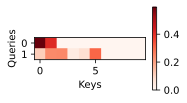

In [8]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## [**加性注意力**]
:label:`subsec_additive-attention`

当查询 $\mathbf{q}$ 和键 $\mathbf{k}$ 是不同维度的向量时，我们可以通过 $\mathbf{q}^\top \mathbf{M} \mathbf{k}$ 使用一个矩阵来解决不匹配问题，或者我们可以使用加性注意力作为评分函数。另一个好处是，顾名思义，注意力是加性的。这可以带来一些轻微的计算节省。给定一个查询 $\mathbf{q} \in \mathbb{R}^q$ 和一个键 $\mathbf{k} \in \mathbb{R}^k$，*加性注意力* 评分函数 :cite:`Bahdanau.Cho.Bengio.2014` 表示为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
:eqlabel:`eq_additive-attn`

其中 $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$, 和 $\mathbf w_v\in\mathbb R^{h}$ 是可学习参数。然后将该术语输入到 softmax 中以确保非负性和归一化。:eqref:`eq_additive-attn` 的等效解释是查询和键被连接起来并送入具有单个隐藏层的 MLP。使用 $\tanh$ 作为激活函数并禁用偏置项，我们实现加性注意力如下：

In [9]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

让我们[**看看`AdditiveAttention`是如何工作的**]。在我们的玩具示例中，我们选择的查询、键和值的大小分别为$(2, 1, 20)$、$(2, 10, 2)$和$(2, 10, 4)$。这与我们对`DotProductAttention`的选择相同，只是现在查询是$20$维的。同样，我们选择$(2, 6)$作为小批量中序列的有效长度。

In [10]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

在回顾注意力函数时，我们看到其行为与`DotProductAttention`的质量上非常相似。也就是说，只有在选定的有效长度(2, 6)内的项是非零的。

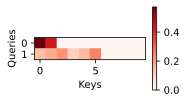

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 摘要

在这一节中，我们介绍了两种关键的注意力评分函数：点积注意力和加性注意力。它们是处理可变长度序列的有效工具。特别是，点积注意力是现代Transformer架构的基础。当查询和键是不同长度的向量时，我们可以使用加性注意力评分函数。优化这些层是近年来的一个关键进展领域。例如，[NVIDIA的Transformer库](https://docs.nvidia.com/deeplearning/transformer-engine/user-guide/index.html)和Megatron :cite:`shoeybi2019megatron` 严重依赖于高效的注意力机制变体。在后面的章节中，当我们回顾Transformers时，我们将更详细地探讨这一点。

## 练习

1. 通过修改`DotProductAttention`代码来实现基于距离的注意力。请注意，为了高效实现，您只需要键的平方范数 $\|\mathbf{k}_i\|^2$。
1. 通过使用矩阵调整维度，修改点积注意力以允许不同维度的查询和键。
1. 计算成本如何随键、查询、值及其数量的维度变化？内存带宽需求又如何变化？

[讨论](https://discuss.d2l.ai/t/1064)